In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norm,kstest,shapiro,t
import pylab

## Problem1:
Compare the conditional distribution of the Multivariate Normal, to the OLS equations. Are these values the same? Why? Use the data in problem1.csv to prove your answer empirically.

Suppose that 𝐗∼𝑁2(𝜇,𝚺)
Then the conditional distribution of 𝑋1 given that 𝑋2=𝑥2 is multivariate normally distributed with mean:
$$ E[P(X_1|X_2=x_2)] = \mu_1 + \frac{\sigma_{12}}{\sigma_{22}}(x_2-\mu_2)$$
and the variance:
$$ Var[P(X_1|X_2=x_2)] = \sigma_{11}-\frac{\sigma_{12}^2}{\sigma_{22}}$$

### Conditional Mutivariate Normal

In [2]:
# read data
df = pd.read_csv("./problem1.csv")
X = np.array(df["x"])
Y = np.array(df["y"])

# calculate the mean of X,Y
mu1 = np.mean(Y)
mu2 = np.mean(X)

sigMat = np.cov(X,Y)
# calculate the Y_hat by using conditional multivariate normal distribution
y_hat = mu1+sigMat[0][1]/sigMat[0][0]*(X-mu2)

# calculate the variance of Y
ConVar_y = sigMat[1][1]-sigMat[0][1]*sigMat[0][1]/sigMat[0][0]
ConVar_y

0.6579563030192094

### OLS regression

Consider the OLS equation:
$$Y = \beta X+e$$
when giving the conditional X=x
then the expectation of the random variable Y is as follows:
$$E[Y|x] = E[\beta X|x + e|x] = E[x]$$
then we can get the var of the conditional Y
$$Var[Y|x] = Var[\beta X|x + e|x] = Var[e]$$


In [3]:
#add a constant
X_ = sm.add_constant(X)
model = sm.OLS(Y, X_) #model OLS
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     35.89
Date:                Thu, 13 Jan 2022   Prob (F-statistic):           3.47e-08
Time:                        22:27:07   Log-Likelihood:                -120.46
No. Observations:                 100   AIC:                             244.9
Df Residuals:                      98   BIC:                             250.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0379      0.082      0.461      0.6

In [4]:
# get the params result 
beta = results.params[1]
c = results.params[0]
error = Y - X*beta - c

# calculate the mean
x_mean = np.mean(results.fittedvalues)
# calculate the var
err_var = np.sum(results.resid**2)/results.df_resid
err_var = results.scale
err_var

0.6646701428459357

Conclusion: 1.As shown in the figure, the two fitting curves overlap, so the conditional mean of Y is the same as outcome of OLS mean.
2. the variance of conditional multivariate normal is 0.658, which is different with the OLS variance 0.6647


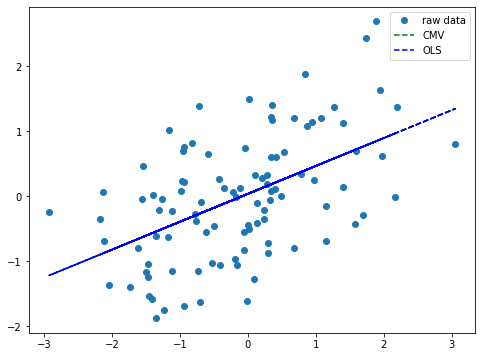

In [5]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(X, Y, 'o', label="raw data")
ax.plot(X, y_hat, 'g--', label="CMV")
ax.plot(X, results.fittedvalues, 'b--', label="OLS")
ax.legend(loc='best')
print("Conclusion: 1.As shown in the figure, the two fitting curves overlap, so the conditional mean of Y is the same as outcome of OLS mean.")
print(f"2. the variance of conditional multivariate normal is {round(ConVar_y,4)}, which is different with the OLS variance {round(err_var,4)}")



## Problem 2:
Fit the data in problem2.csv using OLS and calculate the error vector. Look at it’s distribution. How well does it fit the assumption of normally distributed errors?

Fit the data using MLE given the assumption of normality. Then fit the MLE using the assumption of a T distribution of the errors. Which is the best fit? What are the fitted parameters of each and how do they compare? 

What does this tell us about the breaking of the normality assumption in regards to expected values in this case?

In [6]:
# read data
df = pd.read_csv("./problem2.csv")
X = np.array(df["x"])
Y = np.array(df["y"])

### Conclusion1

The OLS regression params[β0, β1] are: [0.1198362  0.60520482]


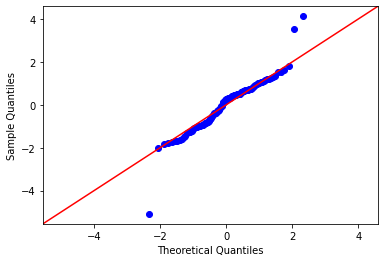

The QQplot shows that error may not be normally distributed.
The shapiro test result: stat=0.938, p=0.000
Data does not follow Normal Distribution


In [7]:
# OLS regression
X_ = sm.add_constant(X)
model = sm.OLS(Y, X_)
results = model.fit()
print("The OLS regression params[β0, β1] are:", results.params)
error = Y-X*results.params[1]-results.params[0]
sm.qqplot(error, line='45')
pylab.show()
print("The QQplot shows that error may not be normally distributed.")


stat, p = shapiro(error)
print('The shapiro test result: stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print("Data follows Normal Distribution")
else:
    print("Data does not follow Normal Distribution")

In [8]:
def norm_log_lik(par_vec, y, x):
    e = y - par_vec[0] - par_vec[1]*x
    lik = -np.log(norm(0,par_vec[2]).pdf(e)).sum()
    return lik

In [9]:
def t_log_lik(par_vec, y, x):
    e = y - par_vec[0] - par_vec[1]*x
    return -np.log(t(df = len(y)-2).pdf(e)).sum()

In [10]:
import scipy.optimize as optimize
# optimize the params
opt_res_t = optimize.minimize(fun = t_log_lik, 
                            x0 = [0, 0], 
                            args = (Y, X))
opt_res_norm = optimize.minimize(fun = norm_log_lik, 
                            x0 = [0, 0, 1], 
                            args = (Y, X))

print(f"When using the assumption of a T distribution of the errors. The optimized params are β0 = {round(opt_res_t.x[0],4)},β1 = {round(opt_res_t.x[1],4)}")
print(f"When using the assumption of a normal distribution of the errors. The optimized params are β0 = {round(opt_res_norm.x[0],4)},β1= {round(opt_res_norm.x[1],4)}")

print("The params of OLS results are", sm.OLS(Y, sm.add_constant(X)).fit().params)


When using the assumption of a T distribution of the errors. The optimized params are β0 = 0.1233,β1 = 0.5951
When using the assumption of a normal distribution of the errors. The optimized params are β0 = 0.1198,β1= 0.6052
The params of OLS results are [0.1198362  0.60520482]


In [11]:
# let me calculate the variance of error to find the best fit params
e_t = Y - opt_res_t.x[0] - opt_res_t.x[1]*X
e_norm = Y - opt_res_norm.x[0] - opt_res_norm.x[1]*X
SSE_t = sum(e_t*e_t)
SSE_norm = sum(e_norm*e_norm)
SSE_t, SSE_norm

(143.62564579636415, 143.6148485406263)

### Conclusion 2 and 3
Compared with 2 distributions of sum of standard error, the SSE of t distribution 143.6256 is larger than SSE of normal distribution assumption 143.6148.

In this case, the assumption of normality cannot be broken, because the sum of square residuals of the T-distribution hypothesis is larger than that of the normal distribution hypothesis, indicating that the goodness of fit of the T-distribution hypothesis is not a good model.

## Problem3:
Simulate AR(1) through AR(3) and MA(1) through MA(3) processes. Compare their ACF and PACF graphs. How do the graphs help us to identify the type and order of each process?

In [19]:
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf

def ar_process_figure(params,titles):
    length = len(params)
    fig, axes = plt.subplots(length,3,figsize = (5*length,3*length))
    for i in range(len(params)):
        process = ArmaProcess(ar = params[i])
        simulated_data = process.generate_sample(nsample=1000)
        axes[i][0].plot(simulated_data)
        axes[i][0].set_title(titles[i])
        fig = plot_acf(simulated_data, alpha=0.1, lags=20, ax=axes[i][1])
        fig = plot_pacf(simulated_data, alpha=0.1, lags=20, ax=axes[i][2])
        
def ma_process_figure(params,titles):
    length = len(params)
    fig, axes = plt.subplots(length,3,figsize = (5*length,3*length))
    for i in range(len(params)):
        process = ArmaProcess(ma = params[i])
        simulated_data = process.generate_sample(nsample=1000)
        axes[i][0].plot(simulated_data)
        axes[i][0].set_title(titles[i])
        fig = plot_acf(simulated_data, alpha=0.1, lags=20, ax=axes[i][1])
        fig = plot_pacf(simulated_data, alpha=0.1, lags=20, ax=axes[i][2])


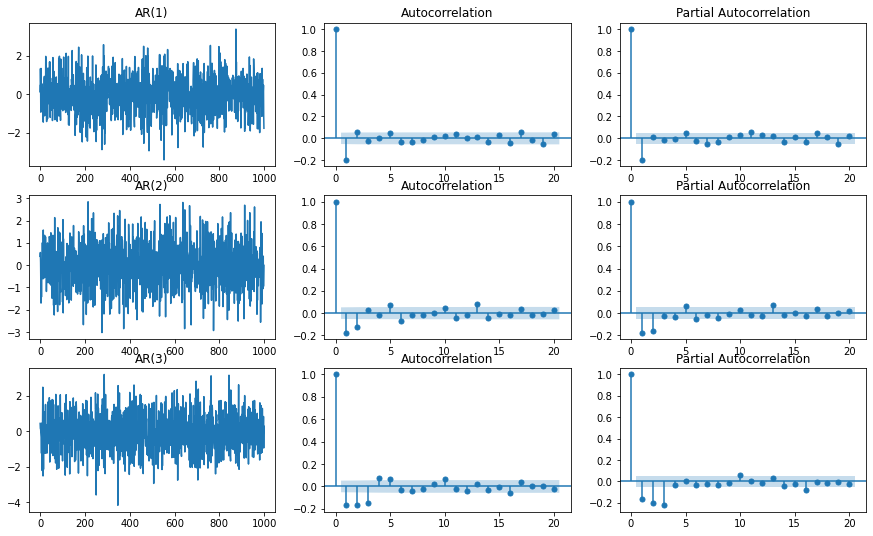

In [20]:
ar_coefs = [[1,0.2],[1,0.2,0.2],[1,0.2,0.2,0.2]]
ar_titles = ["AR(1)","AR(2)","AR(3)"]

ar_process_figure(ar_coefs, ar_titles)

### Conclusion1
In the autocorrelation figures, the coefficient is slowly decaying. it suggests that the time series can probably be modelled with an autoregressive process.

As you can see, in the partial autocorrelation figure, the coefficients are not significant after orresponding number. For example, in the AR(3), the coef is not significant after lag 3. Therefore, the partial autocorrelation plot is useful to determine the order of an AR(p) process. For an AR model, the theoretical PACF “shuts off” past the order of the model.

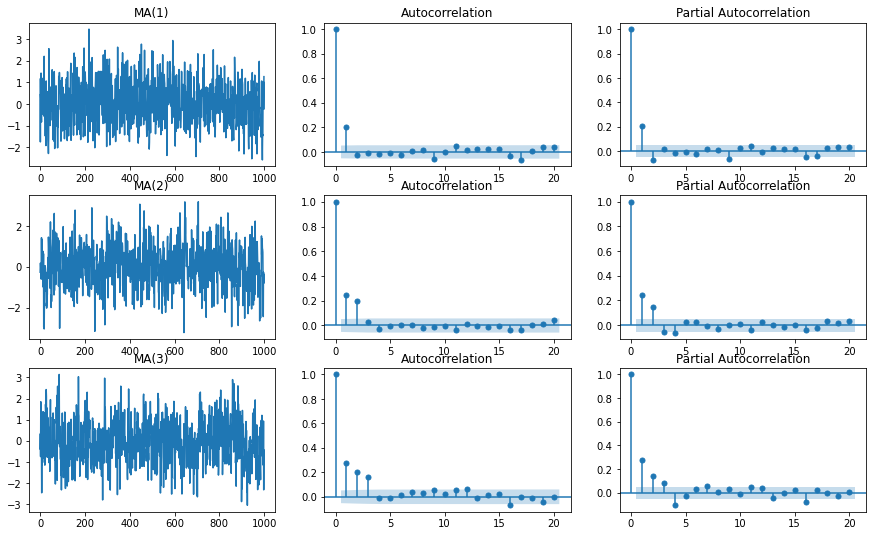

In [21]:
ma_coefs = [[1,0.2],[1,0.2,0.2],[1,0.2,0.2,0.2]]
ma_titles = ["MA(1)","MA(2)","MA(3)"]

ma_process_figure(ma_coefs, ma_titles)

### Conclusion2
The ACF and PACF plots indicate that an the ACF figure in the MA(q) model would be cuts after q lag while the PACF shows a slowly decreasing
Therefore, the autocorrelation plot is useful to determine the order of an MA(p) process.